# Подготовка модели распознавания рукописных букв и цифр

## Загрузка библиотек

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import ToTensor, Compose, Normalize
from torchinfo import summary
from torchvision.datasets import EMNIST
import matplotlib.pyplot as plt
import emnist

## Загрузка датасета

In [2]:
transform = Compose([
    ToTensor(),
    Normalize([0.5], [0.5])
])


train_dataset = emnist.extract_training_samples('balanced')
test_dataset = emnist.extract_test_samples('balanced')




In [3]:
images_train, labels_train = train_dataset
images_test, labels_test = test_dataset
print(f'Train: {len(images_train)} samples')
print(f'Test: {len(images_test)} samples')
print(f'Image size: {images_train[0].shape}')

Train: 112800 samples
Test: 18800 samples
Image size: (28, 28)


In [4]:
train_dataset = [(transform(img), torch.tensor(label)) for img, label in zip(images_train, labels_train)]
test_dataset = [(transform(img), torch.tensor(label)) for img, label in zip(images_test, labels_test)]

/Users/macbook/miniconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:153: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1708025536958/work/torch/csrc/utils/tensor_numpy.cpp:212.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


In [5]:
mapping_dict = {}

with open('emnist-balanced-mapping.txt', 'r') as file:
    for line in file:
        key, value = line.strip().split()
        mapping_dict[int(key)] = int(value)

print(mapping_dict)

{0: 48, 1: 49, 2: 50, 3: 51, 4: 52, 5: 53, 6: 54, 7: 55, 8: 56, 9: 57, 10: 65, 11: 66, 12: 67, 13: 68, 14: 69, 15: 70, 16: 71, 17: 72, 18: 73, 19: 74, 20: 75, 21: 76, 22: 77, 23: 78, 24: 79, 25: 80, 26: 81, 27: 82, 28: 83, 29: 84, 30: 85, 31: 86, 32: 87, 33: 88, 34: 89, 35: 90, 36: 97, 37: 98, 38: 100, 39: 101, 40: 102, 41: 103, 42: 104, 43: 110, 44: 113, 45: 114, 46: 116}


## Изучение данных

In [65]:
images_train[0].shape, images_test[0].shape

((28, 28), (28, 28))

In [22]:
labels_train[0]

tensor(45)

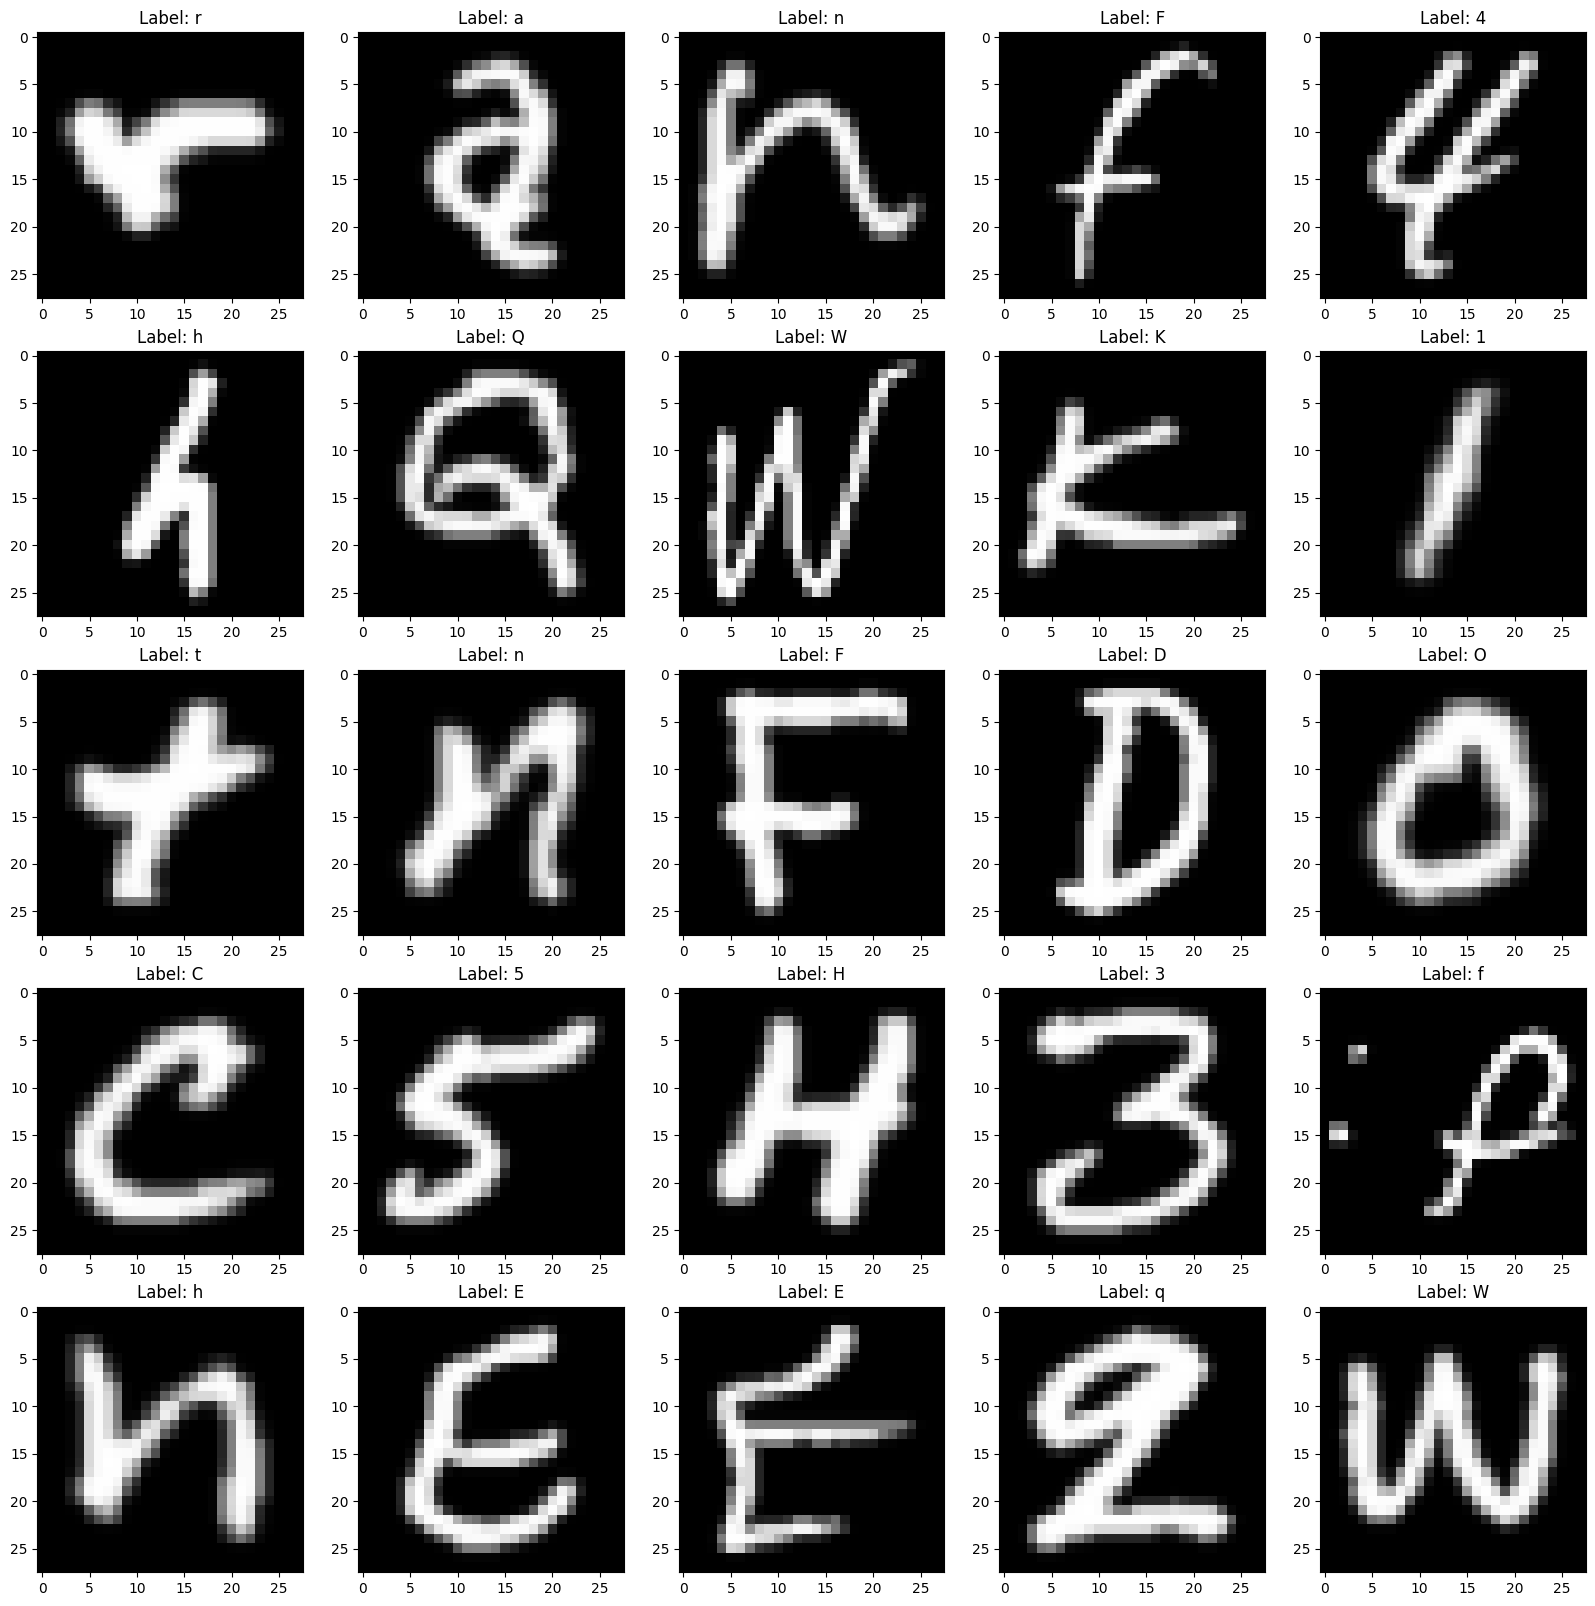

In [66]:
fig, axs = plt.subplots(5, 5, figsize=(20, 20))

for i in range(5):
    for j in range(5):
        index = i * 5 + j
        axs[i, j].imshow(images_train[index], cmap='gray')
        axs[i, j].set_title(f'Label: {chr(mapping_dict[labels_train[index].item()])}')
if index < 24:
    for i in range(index+1, 25):
        axs[i // 5, i % 5].axis('off')
plt.show()

## Подготовка данных

In [6]:
train_loader = DataLoader(train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

## Model

### Train and val functions

In [7]:
def train(model, optimizer, loss_func, train_loader, val_loader, n_epoch):
    model.train()

    for epoch in range(n_epoch):
        loss_sum = 0
        print(f'Epoch: {epoch}')
        for step, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()
            output = model(data).squeeze(1)
            loss = loss_func(output, target)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()
            if step % 10 == 0:
                print(f'Iter: {step} \tLoss: {loss.item()}')

        print(f'Mean train loss: {loss_sum / (step+1):.6f}', end ='\n\n')        
        if epoch % 10 == 0:
            valid(model, val_loader)
        
def valid(model, val_loader):
    model.eval()
    loss_sum = 0
    correct = 0
    for step, (data, target) in enumerate(val_loader):
        with torch.inference_mode():
            output = model(data).squeeze(1)
            loss = loss_func(output, target)
        loss_sum += loss.item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
    acc = correct / len(val_loader.dataset)

    print(f'val loss: {loss_sum / (step+1):.3f} \t Accuracy: {acc}')
    model.train()

### model_1

In [8]:
import torch
import torch.nn as nn

class Model_1(nn.Module):
    def __init__(self, inp: int, hidden_u: int, output: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(inp, hidden_u, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_u),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_u, hidden_u, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(hidden_u),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_u * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(128, output)
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

In [9]:
model_1 = Model_1(inp = 1,
                  hidden_u = 10,
                  output = len(mapping_dict))
summary(model_1, input_size=(1, 1, 28, 28))

/Users/macbook/miniconda3/lib/python3.11/site-packages/torch/nn/functional.py:1347: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Layer (type:depth-idx)                   Output Shape              Param #
Model_1                                  [1, 47]                   --
├─Sequential: 1-1                        [1, 10, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 10, 28, 28]           100
│    └─BatchNorm2d: 2-2                  [1, 10, 28, 28]           20
│    └─ReLU: 2-3                         [1, 10, 28, 28]           --
│    └─MaxPool2d: 2-4                    [1, 10, 14, 14]           --
├─Sequential: 1-2                        [1, 10, 7, 7]             --
│    └─Conv2d: 2-5                       [1, 10, 14, 14]           910
│    └─BatchNorm2d: 2-6                  [1, 10, 14, 14]           20
│    └─ReLU: 2-7                         [1, 10, 14, 14]           --
│    └─MaxPool2d: 2-8                    [1, 10, 7, 7]             --
├─Sequential: 1-3                        [1, 47]                   --
│    └─Flatten: 2-9                      [1, 490]                  --
│    └─Linear

#### optimier, loss

In [10]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)
n_epoch = 50

In [11]:
train(model_1, optimizer, loss_func, train_loader, test_loader, n_epoch)

Epoch: 0
Iter: 0 	Loss: 3.868431329727173
Iter: 10 	Loss: 3.6505465507507324
Iter: 20 	Loss: 3.22719407081604
Iter: 30 	Loss: 2.794646978378296
Iter: 40 	Loss: 2.262247085571289
Iter: 50 	Loss: 2.0271854400634766
Iter: 60 	Loss: 1.7612102031707764
Iter: 70 	Loss: 1.5822956562042236
Iter: 80 	Loss: 1.4792762994766235
Iter: 90 	Loss: 1.3963650465011597
Iter: 100 	Loss: 1.279577374458313
Iter: 110 	Loss: 1.2040653228759766
Mean train loss: 2.178765

val loss: 0.806 	 Accuracy: 0.7579255319148936
Epoch: 1
Iter: 0 	Loss: 1.2531932592391968
Iter: 10 	Loss: 1.1187347173690796
Iter: 20 	Loss: 1.130029559135437
Iter: 30 	Loss: 1.0584044456481934
Iter: 40 	Loss: 1.1060200929641724
Iter: 50 	Loss: 1.0219998359680176
Iter: 60 	Loss: 0.9628497958183289
Iter: 70 	Loss: 0.9764158129692078
Iter: 80 	Loss: 0.942512035369873
Iter: 90 	Loss: 0.8384124040603638
Iter: 100 	Loss: 0.8549125790596008
Iter: 110 	Loss: 0.7585797905921936
Mean train loss: 0.984411

Epoch: 2
Iter: 0 	Loss: 0.8579218983650208
Iter

In [12]:
valid(model_1, test_loader)

val loss: 0.373 	 Accuracy: 0.8715425531914893


### model_2

In [13]:
class Model_2(nn.Module):
    def __init__(self, inp: int, hidden_u: int, output: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(inp, hidden_u, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_u),
            nn.Conv2d(hidden_u, hidden_u, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_u),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*hidden_u * 7 * 7, 256),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(128, output)            
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.classifier(x)
        return x

In [14]:
model_2 = Model_2(inp = 1,
                  hidden_u = 10,
                  output = len(mapping_dict))
summary(model_2, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model_2                                  [1, 47]                   --
├─Sequential: 1-1                        [1, 10, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 10, 28, 28]           100
│    └─ReLU: 2-2                         [1, 10, 28, 28]           --
│    └─BatchNorm2d: 2-3                  [1, 10, 28, 28]           20
│    └─Conv2d: 2-4                       [1, 10, 28, 28]           910
│    └─ReLU: 2-5                         [1, 10, 28, 28]           --
│    └─BatchNorm2d: 2-6                  [1, 10, 28, 28]           20
│    └─MaxPool2d: 2-7                    [1, 10, 14, 14]           --
├─Sequential: 1-2                        [1, 47]                   --
│    └─Flatten: 2-8                      [1, 1960]                 --
│    └─Linear: 2-9                       [1, 256]                  502,016
│    └─ReLU: 2-10                        [1, 256]                  --
│    └─D

In [15]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
n_epoch = 50
train(model_2, optimizer, loss_func, train_loader, test_loader, n_epoch)



Epoch: 0
Iter: 0 	Loss: 3.8753206729888916
Iter: 10 	Loss: 3.288280963897705
Iter: 20 	Loss: 2.6266965866088867
Iter: 30 	Loss: 2.1313588619232178
Iter: 40 	Loss: 1.7972906827926636
Iter: 50 	Loss: 1.5914678573608398
Iter: 60 	Loss: 1.3888920545578003
Iter: 70 	Loss: 1.2750647068023682
Iter: 80 	Loss: 1.1861032247543335
Iter: 90 	Loss: 1.0816322565078735
Iter: 100 	Loss: 1.0032122135162354
Iter: 110 	Loss: 0.8829175233840942
Mean train loss: 1.781654

val loss: 0.628 	 Accuracy: 0.8016489361702127
Epoch: 1
Iter: 0 	Loss: 1.0540990829467773
Iter: 10 	Loss: 0.9202447533607483
Iter: 20 	Loss: 0.8549250364303589
Iter: 30 	Loss: 0.8721835613250732
Iter: 40 	Loss: 0.8306901454925537
Iter: 50 	Loss: 0.8478430509567261
Iter: 60 	Loss: 0.7668315768241882
Iter: 70 	Loss: 0.7506983280181885
Iter: 80 	Loss: 0.8161629438400269
Iter: 90 	Loss: 0.7368326187133789
Iter: 100 	Loss: 0.7767287492752075
Iter: 110 	Loss: 0.7951845526695251
Mean train loss: 0.811967

Epoch: 2
Iter: 0 	Loss: 0.66290521621704

In [16]:
valid(model_2, test_loader)

val loss: 0.421 	 Accuracy: 0.8753723404255319


## Model 3

In [17]:
class Model_3(nn.Module):
    def __init__(self, inp: int, hidden_u: int, output: int):
        super().__init__()

        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(inp, hidden_u, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_u),
            nn.Conv2d(hidden_u, hidden_u, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(hidden_u),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4*hidden_u * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout2d(0.5),
            nn.Linear(256, output)            
        )

    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.classifier(x)
        return x

In [21]:
model_3 = Model_3(inp = 1,
                  hidden_u = 20,
                  output = len(mapping_dict))
summary(model_3, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
Model_3                                  [1, 47]                   --
├─Sequential: 1-1                        [1, 20, 14, 14]           --
│    └─Conv2d: 2-1                       [1, 20, 28, 28]           200
│    └─ReLU: 2-2                         [1, 20, 28, 28]           --
│    └─BatchNorm2d: 2-3                  [1, 20, 28, 28]           40
│    └─Conv2d: 2-4                       [1, 20, 28, 28]           3,620
│    └─ReLU: 2-5                         [1, 20, 28, 28]           --
│    └─BatchNorm2d: 2-6                  [1, 20, 28, 28]           40
│    └─AvgPool2d: 2-7                    [1, 20, 14, 14]           --
├─Sequential: 1-2                        [1, 47]                   --
│    └─Flatten: 2-8                      [1, 3920]                 --
│    └─Linear: 2-9                       [1, 512]                  2,007,552
│    └─ReLU: 2-10                        [1, 512]                  --
│   

In [24]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.0001)
n_epoch = 10
train(model_3, optimizer, loss_func, train_loader, test_loader, n_epoch)

Epoch: 0
Iter: 0 	Loss: 0.2987147867679596
Iter: 10 	Loss: 0.2847697138786316
Iter: 20 	Loss: 0.29174789786338806
Iter: 30 	Loss: 0.268135666847229
Iter: 40 	Loss: 0.25749942660331726
Iter: 50 	Loss: 0.2710611820220947
Iter: 60 	Loss: 0.2841300666332245
Iter: 70 	Loss: 0.24292534589767456
Iter: 80 	Loss: 0.28948861360549927
Iter: 90 	Loss: 0.2962955832481384
Iter: 100 	Loss: 0.2445472627878189
Iter: 110 	Loss: 0.2721821069717407
Mean train loss: 0.282088

val loss: 0.340 	 Accuracy: 0.8861702127659574
Epoch: 1
Iter: 0 	Loss: 0.2514154613018036
Iter: 10 	Loss: 0.26989492774009705
Iter: 20 	Loss: 0.2574130892753601
Iter: 30 	Loss: 0.25880199670791626
Iter: 40 	Loss: 0.26959243416786194
Iter: 50 	Loss: 0.26303693652153015
Iter: 60 	Loss: 0.2685513198375702
Iter: 70 	Loss: 0.2580472230911255
Iter: 80 	Loss: 0.27376312017440796
Iter: 90 	Loss: 0.2764442563056946
Iter: 100 	Loss: 0.30971798300743103
Iter: 110 	Loss: 0.3163493871688843
Mean train loss: 0.266697

Epoch: 2
Iter: 0 	Loss: 0.2315

In [25]:
valid(model_3, test_loader)

val loss: 0.341 	 Accuracy: 0.8877127659574469


# Evaluation

In [41]:
import random
#random.seed(42)
test_samples=[]
test_labels=[]
for sample, label in random.sample(list(test_dataset), k=16):
  test_samples.append(sample)
  test_labels.append(label)


print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({chr(mapping_dict[test_labels[0].item()])})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 7 (7)


In [42]:
def make_predictions(model: torch.nn.Module, data: list):
  pred_probs=[]
  model.eval()

  with torch.inference_mode():
    for sample in data:
      sample = torch.unsqueeze(sample, dim=0)
      pred_logit = model(sample)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      pred_probs.append(pred_prob)

  return torch.stack(pred_probs)

In [46]:
pred_probs = make_predictions(model_3, test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([ 7, 41, 13, 38, 38,  3, 46,  1, 40, 43, 43, 45, 38, 12, 20, 15])

In [47]:
test_labels

[tensor(7, dtype=torch.uint8),
 tensor(41, dtype=torch.uint8),
 tensor(13, dtype=torch.uint8),
 tensor(38, dtype=torch.uint8),
 tensor(38, dtype=torch.uint8),
 tensor(3, dtype=torch.uint8),
 tensor(46, dtype=torch.uint8),
 tensor(1, dtype=torch.uint8),
 tensor(40, dtype=torch.uint8),
 tensor(43, dtype=torch.uint8),
 tensor(43, dtype=torch.uint8),
 tensor(45, dtype=torch.uint8),
 tensor(38, dtype=torch.uint8),
 tensor(12, dtype=torch.uint8),
 tensor(20, dtype=torch.uint8),
 tensor(40, dtype=torch.uint8)]

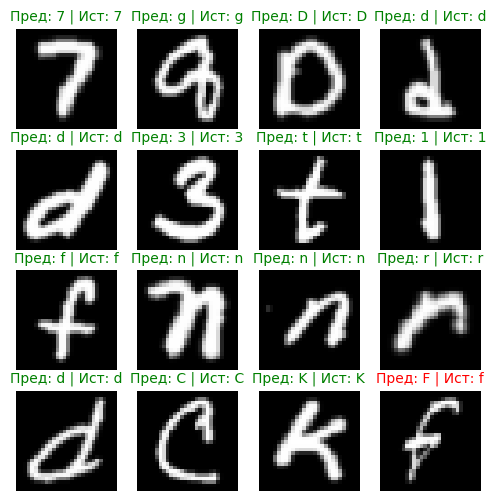

In [48]:
plt.figure(figsize=(6,6))
rows, cols = 4, 4

for i, sample in enumerate(test_samples):
  plt.subplot(rows, cols, i+1)
  plt.imshow(sample.squeeze(), cmap='gray')
  pred_label = pred_classes[i]
  test_label = test_labels[i]
  title_text = f"Пред: {chr(mapping_dict[pred_label.item()])} | Ист: {chr(mapping_dict[test_label.item()])}"
  if pred_label == test_label:
    plt.title(title_text, fontsize=10, c="g")
  else:
    plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)

In [37]:
torch.save(model_3.state_dict(), 'myapp/model_3.ckpt')

In [210]:
torch.save(model_2.state_dict(), 'myapp/model_2.ckpt')